In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import os
from functools import lru_cache
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
torch.__version__, torchvision.__version__

('1.5.0+cu101', '0.6.0+cu101')

## Dataset

In [2]:
data_home = Path(os.environ['HOME'])
data_home = data_home/'.fastai/data/biwi_head_pose'

formula from https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-head-pose.ipynb

In [3]:
class HeadDataset(object):
    def __init__(self, home: Path, transform=None):
        self.home = home
        self.images = list(home.glob('**/*.jpg'))
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    @lru_cache(maxsize=None)
    def cal(self, parent):
        cal = np.genfromtxt(parent/'rgb.cal', skip_footer=6)
        return cal
    
    def pose(self, image: Path):
        p = image.parent
        pose = p/image.name.replace('rgb', 'pose').replace('jpg', 'txt')
        pose = np.genfromtxt(pose, skip_header=3)
        cal = self.cal(p)
        c1 = pose[0] / pose[2] * cal[0, 0] + cal[0, 2]
        c2 = pose[1] / pose[2] * cal[1, 1] + cal[1, 2]
        return int(c1), int(c2)
    
    @staticmethod
    def image_pose(image: Image, pose):
        from PIL import ImageDraw
        
        base = image.convert('RGBA')
        alpha = Image.new('RGBA', base.size, (255, 255, 255, 0))  # white, transparent
        draw = ImageDraw.Draw(alpha)
        pose = np.array(pose)
        pose = np.concatenate([pose - 5, pose + 5])
        draw.ellipse(list(pose), fill=(255, 0, 0, 255))  # red, opaque
        
        return Image.alpha_composite(base, alpha)
    
    def __getitem__(self, index):
        image = Image.open(self.images[index])
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.pose(self.images[index])

In [4]:
dataset = HeadDataset(data_home)

In [10]:
image, pose = dataset[20]
image, pose

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7FC5AF1A4150>,
 (308, 247))

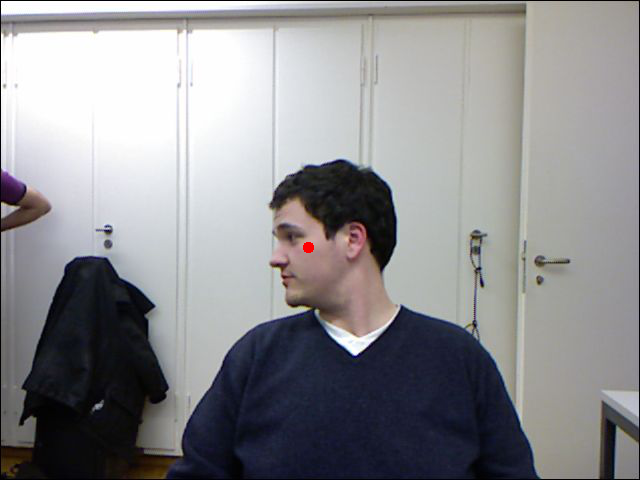

In [11]:
HeadDataset.image_pose(image, pose)